# Neural Architecture Search for Large Language Models

Neural Architecture Search (NAS) is an effective framework to design neural network architectures automatically.
This notebook demonstrates how to utilize NAS for compressing a large language model that has been fine-tuned for a specific target task. The main objective is to reduce the model size while maintaining performance as much as possible. To achieve this, we search for sub-networks within the model that jointly optimize the parameter count and validation error.

Sub-networks can be defined in various ways. In this context, we consider subsets of multi-head attention and fully-connected layers, with a reduced number of heads in the multi-head attention layer and units in the intermediate layers.

Our NAS approach consists of two steps:

1. Initial fine-tuning of the pre-trained model on the target task using weight-sharing based NAS training strategies. The pre-trained model serves as a 'super-network' that encompasses a large, finite set of sub-networks. To prevent sub-networks from co-adapting, we modify the fine-tuning process by updating only specific parts of the network (i.e., subsets of all layers) in each update step.

2. In the second step, we employ multi-objective search through [SageMaker Automated Model Tuning (AMT)](https://aws.amazon.com/sagemaker/automatic-model-tuning/) to identify a set of sub-networks that offer an optimal trade-off between parameter count and validation error for the target task.

Finally, we can visualize the so-called **Pareto set** of architectures that optimally balance between parameter count and validation error, and select the best-suited model that strikes the right balance between model size and validation error for us.

**Limitations:**

- Currently, the notebook limited to the BERT model family.
- We exclusively focus on supervised fine-tuning using labeled datasets.

## Install requirements

Before we get started, we install all requirements

In [ ]:
!pip install -r requirements.txt

## Imports

In [2]:
import logging

import numpy as np
import evaluate
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader

from transformers import (
    AutoTokenizer,
    default_data_collator,
    TrainingArguments,
    AutoModelForSequenceClassification,
    AutoConfig,
)

from training import train_supernetwork
from estimate_efficency import compute_latency
import sagemaker


from datetime import datetime
from sagemaker.huggingface import HuggingFace
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, CategoricalParameter
from sagemaker import get_execution_role

## Hyperparameters

We define all hyperparameters and model type

In [3]:
model_type = "bert-base-cased"
output_dir = "nas_output_dir"
max_seq_length = 128
per_device_train_batch_size = 8
per_device_eval_batch_size = 8
seed = 42

## Load Dataset and Evaluation Metric

For illustration purposes, we use the [Recognizing Textual Entailment](https://aclweb.org/aclwiki/Recognizing_Textual_Entailment) dataset from the [GLUE](https://gluebenchmark.com/) benchmarking suite. The goal of this dataset is to identify whether the meaning of one sentence can be infered from the other sentence. 
Example sentence pair:
 
sentence 1:
*Only a week after it had no comment on upping the storage capacity of its Hotmail e-mail service, Microsoft early Thursday announced it was boosting the allowance to 250MB to follow similar moves by rivals such as Google, Yahoo, and Lycos.*

sentence 2:
*Microsoft's Hotmail has raised its storage capacity to 250MB.*

We load the dataset via the [dataset library](https://huggingface.co/docs/datasets/index) from HuggingFace.

In [ ]:
task_name = "rte"

raw_datasets = load_dataset("glue", task_name)
sentence1_key, sentence2_key = ("sentence1", "sentence2")

metric = evaluate.load("glue", task_name)

## Data Preprocessing

We first preprocess the data using the Tokenizer from HuggingFace. This code is originally from this [example]( https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py)


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_type)

padding = "max_length"

max_seq_length = min(max_seq_length, tokenizer.model_max_length)


def preprocess_function(examples):
    args = (
        (examples[sentence1_key],)
        if sentence2_key is None
        else (examples[sentence1_key], examples[sentence2_key])
    )
    result = tokenizer(*args, padding=padding, max_length=max_seq_length, truncation=True)

    return result


preproc_datasets = raw_datasets.map(
    preprocess_function,
    batched=True,
    desc="Running tokenizer on dataset",
)

label_list = preproc_datasets["train"].features["label"].names
num_labels = len(label_list)

## Split Dataset in Training / Validation

As mentioned earlier, after fine-tuning our 'super-network' on the training dataset, we proceed with a multi-objective search to identify the optimal set of sub-networks that optimally balance between generalization performance and parameter count. Since we cannot directly compute generalization performance, we approximate it by measuring accuracy on a hold-out validation dataset.

To achieve this, we split the original training dataset from GLUE into an training/validation set. The training set is exclusively used for fine-tuning purposes, while the validation data is employed for the subsequent multi-objective search.

In [6]:
train_dataset = preproc_datasets["train"]
test_dataset = preproc_datasets["validation_matched" if task_name == "mnli" else "validation"]

train_dataset = train_dataset.remove_columns(["idx"])
test_dataset = test_dataset.remove_columns(["idx"])

split = train_dataset.train_test_split(train_size=0.7, seed=seed)
train_dataset = split["train"]
valid_dataset = split["test"]


data_collator = default_data_collator

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=per_device_train_batch_size,
    collate_fn=data_collator,
)
eval_dataloader = DataLoader(
    valid_dataset,
    batch_size=per_device_eval_batch_size,
    collate_fn=data_collator,
)

## Load pre-trained Model

Load the [pre-trained BERT model](https://huggingface.co/bert-base-cased) from the HuggingFace hub:

In [ ]:
config = AutoConfig.from_pretrained(
    model_type,
    num_labels=num_labels,
    finetuning_task=task_name,
)
model = AutoModelForSequenceClassification.from_pretrained(
    model_type,
    config=config,
)

## Train weight-sharing based Super-Network

We now fine-tune our pre-training network, i.e super-network. To control the training we can use the [TrainingArguments](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) of the HuggingFace transformer library. We have to pass an additional argument to specify if our dataset is regression or not (determines the loss function)

In [ ]:
training_args = TrainingArguments(output_dir=output_dir)
training_args.is_regression = (
    False  # set this to True if your dataset is a regression dataset, for example STSB
)
training_args.save_strategy = "epoch"
training_args.log_dir = ".log_dir"
training_args.seed = seed
training_args.use_accelerate = False
training_args.num_train_epochs = 10
training_args.learning_rate = 2e-05
training_args.per_device_train_batch_size = per_device_train_batch_size
training_args.per_device_eval_batch_size = per_device_eval_batch_size
train_supernetwork(model, train_dataloader, eval_dataloader, metric, training_args)

## Multi-objective search for sub-networks

After the fine-tuning process, we begin the multi-objective search by sampling random sub-networks using AMT. A sub-network is defined by its number of layers, heads, and units in the intermediate fully connected layers. To access a sub-network, we place a binary mask over the super-network and mask out all components (i.e., heads, units) that are not part of the sub-network. Note that, HuggingFace transformers needs the hidden size to be a multiple of the number of head. We cannot change the hidden size, and hence the number of heads has to be in [1, 3, 6, 12].

In contrast to single-objective optimization, in the multi-objective setting, we typically do not have a single solution that simultaneously optimizes all objectives. Instead, we aim to collect a set of solutions that *dominate* all other solutions in at least one objective.

AMT spaws multiple SageMaker training jobs to evaluate sub-networks. To allows these training jobs to access the checkpoint of our model, we have to first upload it to S3.

In [ ]:
from sagemaker.session import Session
import subprocess


def upload_to_s3(src_dir):

    session = Session()
    s3_bucket = session.default_bucket()
    s3_bucket_prefix = "nas_amt/model_checkpoint"

    s3_path = f"s3://{s3_bucket}/{s3_bucket_prefix}"

    cmd = f"aws s3 sync {src_dir} {s3_path}"
    logging.info(f"upload results to {s3_path} with command {cmd}")
    subprocess.run(cmd.split(" "))

    return s3_path


s3_path = upload_to_s3(output_dir)

Now we can start the multi-objective search through AMT. We sample a total of 100 random sub-networks (defined by the parameter `max_jobs`) and evaluate 10 networks simultaneously (defined by `max_parallel_jobs`). The code to load the model checkpoint and evaluate the sub-network is available in the `evaluate_subnetwork.py` script.

In [ ]:
# Maximum number of sub-networks we will evaluate
max_jobs = 100
max_parallel_jobs = 10

# Entry point script to load the super-network and evaluate a sub-network
entry_point = "evaluate_subnetwork.py"

# Command line arguments for the entry point script
hyperparameters = {"model_name_or_path": model_type, "output_dir": "./tmp", "task_name": "rte"}

# Define the metric we want to maximize
metric_definitions = [
    {"Name": "num-parameters", "Regex": "number of parameters: ([0-9\\.]+)"},
    {"Name": "validation-performance", "Regex": "validation score: ([0-9\\.]+)"},
]

# Define HuggingFace estimator
estimator = HuggingFace(
    entry_point=entry_point,
    source_dir="./",
    instance_type="ml.g4dn.xlarge",  # instance types for the SageMaker training jobs
    instance_count=1,
    py_version="py39",
    framework_version="1.13",
    pytorch_version="1.13",
    transformers_version="4.26",
    max_run=3600 * 72,
    role=get_execution_role(),
    volume_size=125,
    model_uri=s3_path,
    hyperparameters=hyperparameters,
)


current_time = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
tuning_job_name = f"nas-search-{current_time}"

# Search space to define sub-networks
hyperparameter_ranges = {
    "num_layers": IntegerParameter(0, 12),
    # To meet HuggingFace constraints, we can only set the number of head to these values
    "num_heads": CategoricalParameter([1, 3, 6, 12]),
    "num_units": IntegerParameter(0, 3072),
}

# Define AMT Tuner object
my_tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name="validation-performance",
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    max_jobs=max_jobs,
    strategy="Random",
    random_seed=seed,
    max_parallel_jobs=max_parallel_jobs,
)

# Start hyperparameter tuning job
my_tuner.fit(job_name=tuning_job_name)

## Visualize Results

To visualize our results, we parse AMT's history to collect all configurations of sub-networks and the corresponding metrics:

In [27]:
history = my_tuner.analytics().dataframe()
data = []
configs = []
for i, t in enumerate(my_tuner.analytics().training_job_summaries()):
    jn = t["TrainingJobName"]
    df = sagemaker.analytics.TrainingJobAnalytics(jn).dataframe()

    row = history[history["TrainingJobName"] == jn]
    config = {
        "num_heads": int(row["num_heads"].iloc[0].strip('"')),
        "num_layers": int(row["num_layers"]),
        "num_units": int(row["num_units"]),
    }
    configs.append(config)

    p = []
    for j, metric in enumerate(metric_definitions):
        metric_name = metric["Name"]
        if "metric_name" not in df.keys():
            continue

        if metric_name == "validation-performance":
            y = 1 - float(df[df["metric_name"] == metric_name]["value"])
        else:
            y = float(df[df["metric_name"] == metric_name]["value"])
        p.append(y)
    if len(p) > 0:
        data.append(p)

data = np.array(data)

Just for comparison, we also evaluate the unpruned network.

In [28]:
from evaluate import load

model.eval()
device = torch.device("cuda")
metric = load("glue", task_name)

for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}

    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    metric.add_batch(predictions=predictions, references=batch["labels"])

eval_metric = metric.compute()
validation_error_unpruned_network = 1 - eval_metric["accuracy"]

We now visualize the Pareto set, which represents the optimal set of sub-networks that dominate all other sub-networks in at least one metric. This implies that when we move from one sub-network of the Pareto set to another, we must either sacrifice performance or model size but improve the other.

Ultimately, the Pareto set provides us the flexibility to choose the sub-network that best suits our preferences. We can decide how much we want to reduce the size of our network and how much performance we are willing to sacrifice.

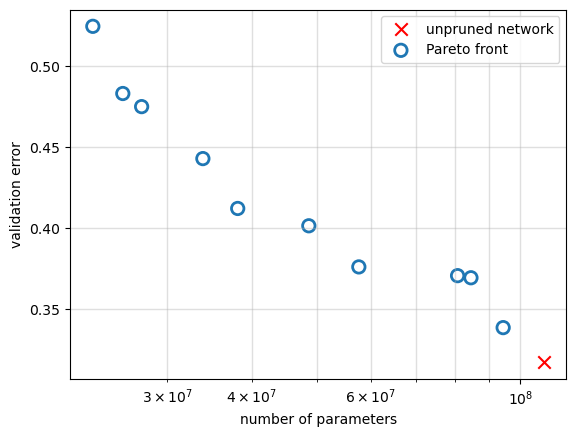

In [29]:
import matplotlib.pyplot as plt
from multi_objective import get_pareto_optimal

n_params_original_model = sum(p.numel() for p in model.parameters() if p.requires_grad)

plt.scatter(
    n_params_original_model,
    validation_error_unpruned_network,
    color="red",
    marker="x",
    s=80,
    label="unpruned network",
)


idx = get_pareto_optimal(data)
x = data[idx, 0]
y = data[idx, 1]

plt.scatter(
    x, y, marker="o", s=80, facecolors="none", edgecolors="C0", linewidth=2, label="Pareto front"
)
plt.xlabel("number of parameters")
plt.ylabel("validation error")
plt.legend()
plt.xscale("log")
plt.grid(linewidth="1", alpha=0.4, which="both")

## Select Final Model

To choose the final sub-network, we create a new model with a new architecture definition and then copy the subset of weights from the super-network into this new model.

In [30]:
from transformers.models.bert.modeling_bert import BertConfig
from extract_subnetworks import get_final_bert_model

# Select the largest sub-network of the Pareto front (lower right figure above)
best = np.arange(data.shape[0])[idx][-1]
architecture_definition = configs[best]

config = BertConfig(
    vocab_size=model.config.vocab_size,
    num_hidden_layers=architecture_definition["num_layers"],
    num_attention_heads=architecture_definition["num_heads"],
    intermediate_size=architecture_definition["num_units"],
)
config.attention_head_size = int(config.hidden_size / model.config.num_attention_heads)

new_model = get_final_bert_model(original_model=model, new_model_config=config)

n_params_full_model = sum(p.numel() for p in model.parameters() if p.requires_grad)

n_params_new_model = sum(p.numel() for p in new_model.parameters() if p.requires_grad)
print(f"Params full model = {n_params_full_model}")
print(f"Params new model = {n_params_new_model}")

Params full model = 108311810
Params new model = 94308975


In [31]:
device = torch.device("cuda")
batch = train_dataset[0][sentence1_key]
latency = compute_latency(model, tokenizer, batch, device)
print(f"Latency full model = {latency}")
new_model.to(device)
latency = compute_latency(new_model, tokenizer, batch, device)
print(f"Latency new model = {latency}")

Latency full model = 10.527280648549398
Latency new model = 9.942786769866943
